In [346]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [347]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# preprocessing and visualisation

In [348]:
df=pd.read_csv("data.csv")

In [349]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1984-09-07,0.100763,0.101999,0.099546,0.100763,9.767604e+07
1,1984-09-10,0.100763,0.101071,0.098340,0.100165,7.581254e+07
2,1984-09-11,0.101071,0.103814,0.101071,0.101999,1.787705e+08
3,1984-09-12,0.101999,0.102597,0.098928,0.098928,1.561713e+08
4,1984-09-13,0.104432,0.104730,0.104432,0.104432,2.432310e+08


In [350]:
df.tail()

,Date,Open,High,Low,Close,Volume
10075,2024-08-30,230.190,230.40,227.48,229.00,52990770.0
10076,2024-09-03,228.550,229.00,221.17,222.77,50190574.0
10077,2024-09-04,221.660,221.78,217.48,220.85,43840196.0
10078,2024-09-05,221.625,225.48,221.52,222.38,36615398.0
10079,2024-09-06,223.950,225.24,219.77,220.86,48370990.0


In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10080 non-null  object 
 1   Open    10080 non-null  float64
 2   High    10080 non-null  float64
 3   Low     10080 non-null  float64
 4   Close   10080 non-null  float64
 5   Volume  10080 non-null  float64
dtypes: float64(5), object(1)
memory usage: 472.6+ KB


In [352]:
df.describe()

,Open,High,Low,Close,Volume
count,10080.000000,10080.000000,10080.000000,10080.000000,1.008000e+04
mean,24.212653,24.474183,23.962728,24.228588,3.901825e+08
std,48.475894,48.997820,47.988301,48.513977,4.026818e+08
min,0.055411,0.056019,0.054803,0.054803,2.811754e+06
25%,0.292936,0.298629,0.286002,0.292288,1.385973e+08
50%,0.884054,0.907432,0.864364,0.883006,2.576699e+08
75%,21.635500,21.869775,21.426925,21.649000,4.927167e+08
max,236.480000,237.230000,233.090000,234.820000,8.706575e+09


### checking for duplicates and null values

In [353]:
df.duplicated().sum()

0

In [354]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

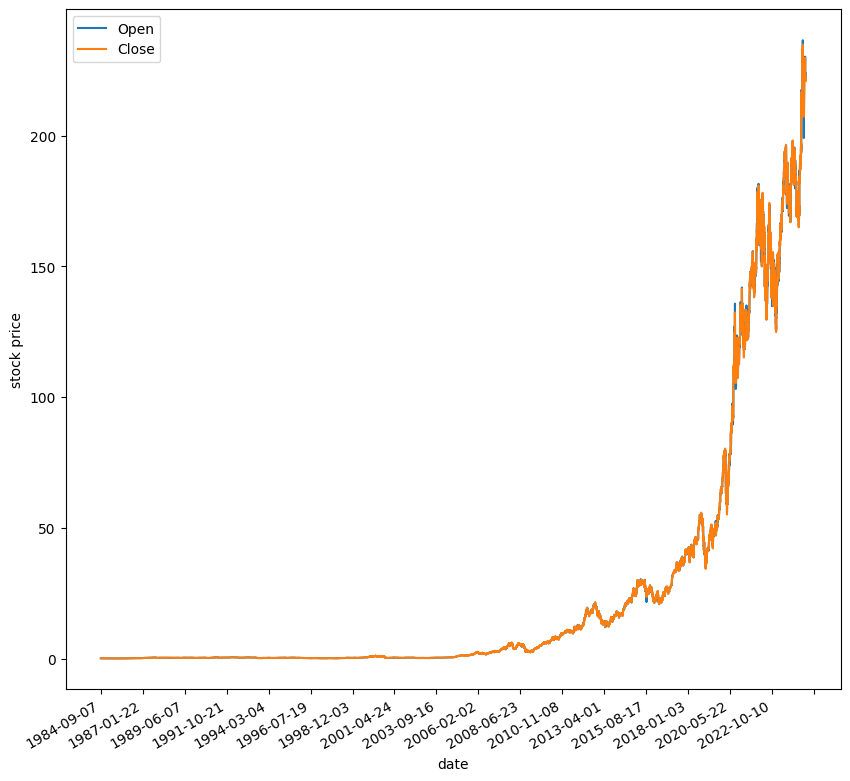

In [355]:
plt.figure(figsize=(10,10))
plt.plot(df["Date"],df["Open"])
plt.plot(df["Date"],df["Close"])
plt.legend(['Open','Close'])
plt.xlabel('date')
plt.ylabel('stock price')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.gcf().autofmt_xdate()

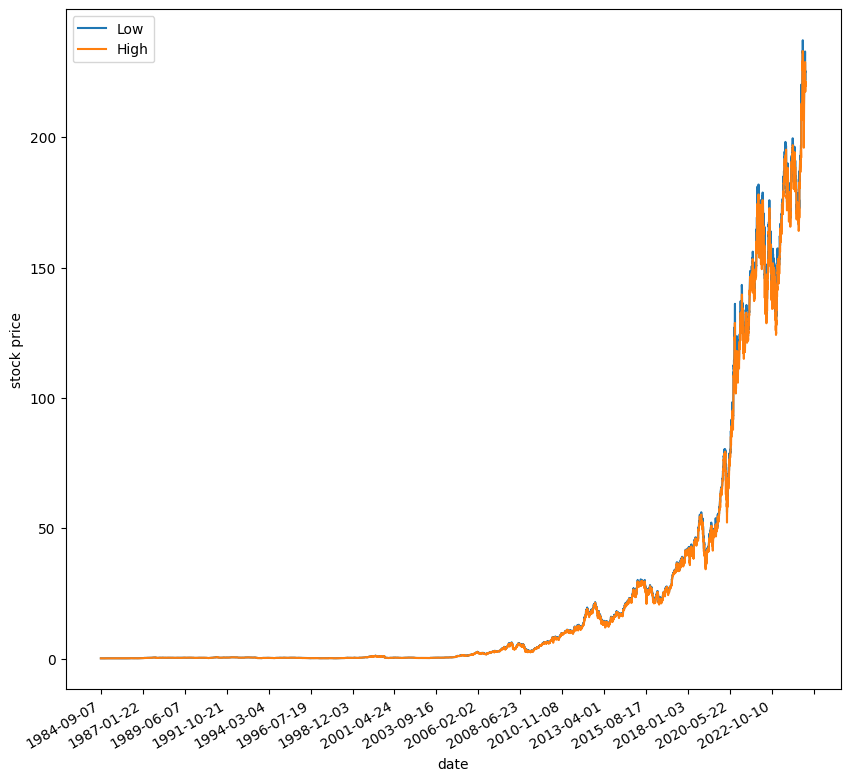

In [356]:
plt.figure(figsize=(10,10))
plt.plot(df["Date"],df["High"])
plt.plot(df["Date"],df["Low"])
plt.legend(['Low','High'])
plt.xlabel('date')
plt.ylabel('stock price')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.gcf().autofmt_xdate()

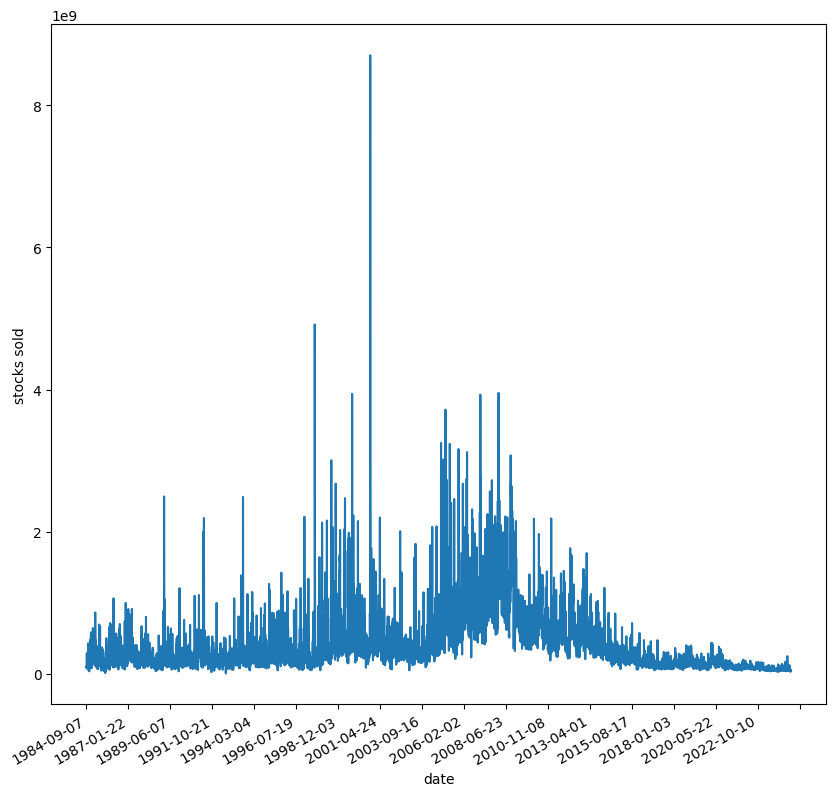

In [357]:
plt.figure(figsize=(10,10))
plt.plot(df["Date"],df["Volume"])
plt.xlabel('date')
plt.ylabel('stocks sold')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.gcf().autofmt_xdate()

<Axes: >

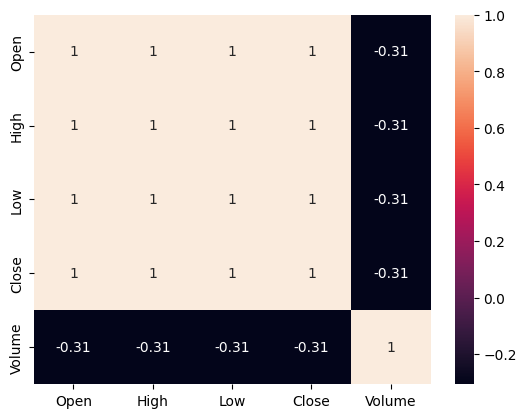

In [358]:
sns.heatmap(df.drop("Date",axis=1).corr(),annot=True)

In [359]:
X=df.drop(["Close",'Date'],axis=1)
y=df["Close"]

In [360]:
MinMaxScaler().fit(X)

MinMaxScaler()

In [361]:
X

,Open,High,Low,Volume
0,0.100763,0.101999,0.099546,9.767604e+07
1,0.100763,0.101071,0.098340,7.581254e+07
2,0.101071,0.103814,0.101071,1.787705e+08
3,0.101999,0.102597,0.098928,1.561713e+08
4,0.104432,0.104730,0.104432,2.432310e+08
...,...,...,...,...
10075,230.190000,230.400000,227.480000,5.299077e+07
10076,228.550000,229.000000,221.170000,5.019057e+07
10077,221.660000,221.780000,217.480000,4.384020e+07
10078,221.625000,225.480000,221.520000,3.661540e+07


In [362]:
def create_sequences(df_2, target, seq_length):
    X, y = [], []
    for i in range(len(df_2) - seq_length):
        X.append(df_2[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50

X, y = create_sequences(X, y, seq_length)


In [363]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Model

In [373]:
model=Sequential()

In [374]:
model.add(LSTM(10,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(5))
# model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1,activation='linear'))

In [375]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics='mean_absolute_error')

In [376]:
with tf.device('/GPU:0'):
    hist=model.fit(X_train,y_train,epochs=50,batch_size=64,validation_split=0.1,verbose=1)

Epoch 1/50
113/113 [==============================] - 5s 20ms/step - loss: 2852.9954 - mean_absolute_error: 24.1155 - val_loss: 2621.5706 - val_mean_absolute_error: 23.8579
Epoch 2/50
113/113 [==============================] - 2s 15ms/step - loss: 2451.8513 - mean_absolute_error: 28.1458 - val_loss: 2313.4595 - val_mean_absolute_error: 30.8550
Epoch 3/50
113/113 [==============================] - 2s 14ms/step - loss: 2349.6333 - mean_absolute_error: 32.1075 - val_loss: 2315.2971 - val_mean_absolute_error: 31.5306
Epoch 4/50
113/113 [==============================] - 2s 14ms/step - loss: 2348.1582 - mean_absolute_error: 32.4164 - val_loss: 2313.6646 - val_mean_absolute_error: 30.4978
Epoch 5/50
113/113 [==============================] - 2s 14ms/step - loss: 2349.6318 - mean_absolute_error: 31.9254 - val_loss: 2313.5664 - val_mean_absolute_error: 30.9671
Epoch 6/50
113/113 [==============================] - 2s 14ms/step - loss: 2349.6973 - mean_absolute_error: 32.2294 - val_loss: 2313.58

In [377]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 50, 10)            600       
                                                                 
 lstm_25 (LSTM)              (None, 5)                 320       
                                                                 
 dense_27 (Dense)            (None, 32)                192       
                                                                 
 dense_28 (Dense)            (None, 16)                528       
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,657
Trainable params: 1,657
Non-trainable params: 0
_________________________________________________________________


# eval

In [378]:
model.evaluate(X_test,y_test)

63/63 [==============================] - 0s 6ms/step - loss: 2432.0518 - mean_absolute_error: 32.9533


[2432.0517578125, 32.95329284667969]

In [379]:
y_pred=model.predict(X_test)

63/63 [==============================] - 1s 6ms/step


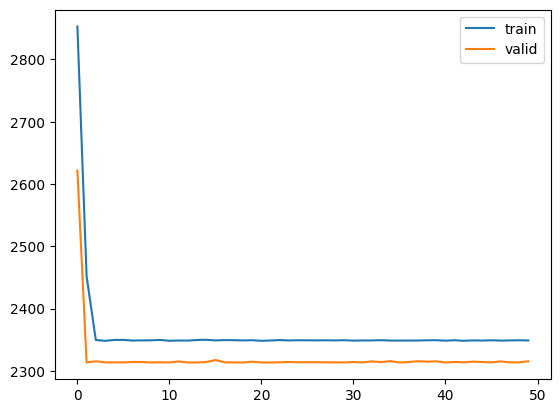

In [380]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train', 'valid'])

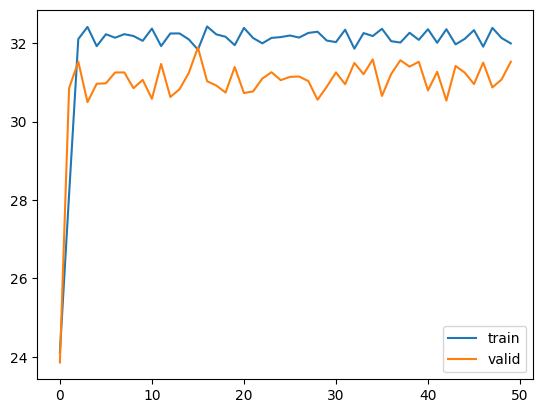

In [381]:
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.legend(['train', 'valid'])

In [382]:
model.save("model.h5")